## Table of Content

* __Step 1: Importing the Relevant Libraries__
    
* __Step 2: Data Inspection__
    
* __Step 3: Data Cleaning__
    
* __Step 4: Exploratory Data Analysis__
    
* __Step 5: Feature Engineering__

* __Step 6: Building Model__
    

### Step 1: Importing the Relevant Libraries

In [276]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


import math

import warnings
warnings.filterwarnings('ignore')

### Step 2: Data Inspection

In [277]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [278]:
train.shape,test.shape

((30000, 24), (20000, 23))

In [279]:
#ratio of null values
print(train.columns)
print(test.columns)

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price', 'Loan Sanction Amount (USD)'],
      dtype='object')
Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price'],
      dtype='object')


In [280]:
#categorical features
categorical = train.select_dtypes(include =[np.object])
print("Categorical Features in Train Set:",categorical.shape[1])

#numerical features
numerical= train.select_dtypes(include =[np.float64,np.int64])
print("Numerical Features in Train Set:",numerical.shape[1])

Categorical Features in Train Set: 11
Numerical Features in Train Set: 13


In [281]:
#categorical features
categorical_ = test.select_dtypes(include =[np.object])
print("Categorical Features in Test Set:",categorical_.shape[1])

#numerical features
numerical_= test.select_dtypes(include =[np.float64,np.int64])
print("Numerical Features in Test Set:",numerical_.shape[1])

Categorical Features in Test Set: 13
Numerical Features in Test Set: 10


In [282]:
print(categorical.columns)
print(categorical_.columns)

Index(['Customer ID', 'Name', 'Gender', 'Income Stability', 'Profession',
       'Type of Employment', 'Location', 'Expense Type 1', 'Expense Type 2',
       'Has Active Credit Card', 'Property Location'],
      dtype='object')
Index(['Customer ID', 'Name', 'Gender', 'Income Stability', 'Profession',
       'Type of Employment', 'Location', 'Expense Type 1', 'Expense Type 2',
       'Has Active Credit Card', 'Property Location', 'Co-Applicant',
       'Property Price'],
      dtype='object')


In [283]:
print(train['Co-Applicant'].value_counts())
print(test['Co-Applicant'].value_counts())

 1      25516
 0       4316
-999      168
Name: Co-Applicant, dtype: int64
1    17004
0     2919
?       77
Name: Co-Applicant, dtype: int64


In [284]:
train['Co-Applicant'] = train['Co-Applicant'].replace(-999,1)
test['Co-Applicant'] = test['Co-Applicant'].replace(['?','1','0'],[1,1,0])
test['Property Price'] = test['Property Price'].replace('?','-999')
test['Property Price'] = test['Property Price'].apply(pd.to_numeric)

In [285]:
print(train['Gender'].value_counts(dropna=False))
print(test['Gender'].value_counts(dropna=False))

M      15053
F      14894
NaN       53
Name: Gender, dtype: int64
F      10142
M       9827
NaN       31
Name: Gender, dtype: int64


In [286]:
train['Gender'] = train['Gender'].fillna('F')
test['Gender'] = test['Gender'].fillna('F')

In [287]:
print(train['Income Stability'].value_counts(dropna=False))
print(test['Income Stability'].value_counts(dropna=False))

Low     25751
High     2566
NaN      1683
Name: Income Stability, dtype: int64
Low     17501
High     1686
NaN       813
Name: Income Stability, dtype: int64


In [288]:
train['Income Stability'] = train['Income Stability'].fillna('Low')
test['Income Stability'] = test['Income Stability'].fillna('Low')

In [289]:
print(train['Profession'].value_counts(dropna=False))
print(test['Profession'].value_counts(dropna=False))

Working                 16926
Commercial associate     7962
Pensioner                2740
State servant            2366
Unemployed                  2
Businessman                 2
Maternity leave             1
Student                     1
Name: Profession, dtype: int64
Working                 11405
Commercial associate     5247
Pensioner                1764
State servant            1577
Student                     4
Unemployed                  2
Maternity leave             1
Name: Profession, dtype: int64


In [290]:
train['Profession']=train['Profession'].replace(['Businessman','Unemployed','Student','Maternity leave'],['Working','Not working','Not working','Working'])
test['Profession']=test['Profession'].replace(['Unemployed','Student','Maternity leave'],['Not working','Not working','Working'])

In [291]:
print(train['Type of Employment'].value_counts(dropna=False))
print(test['Type of Employment'].value_counts(dropna=False))

NaN                      7270
Laborers                 5578
Sales staff              3736
Core staff               3230
Managers                 2495
Drivers                  1606
Accountants              1379
High skill tech staff    1307
Medicine staff            864
Security staff            579
Cooking staff             566
Private service staff     342
Cleaning staff            341
Low-skill Laborers        162
Secretaries               161
Waiters/barmen staff      149
Realty agents              86
IT staff                   77
HR staff                   72
Name: Type of Employment, dtype: int64
NaN                      4689
Laborers                 3743
Sales staff              2433
Core staff               2232
Managers                 1719
Drivers                  1057
Accountants               886
High skill tech staff     881
Medicine staff            598
Cooking staff             405
Security staff            377
Cleaning staff            230
Private service staff     201
L

In [292]:
ranks = {
         'Laborers':1,
        'Sales staff':2,
        'Core staff':3,
        'Managers':4,
        'Drivers':1,
        'Accountants':3,
        'High skill tech staff':4,
        'Medicine staff':4,
        'Security staff':2,
        'Cooking staff':2,
        'Private service staff':3,
        'Cleaning staff':1,
        'Low-skill Laborers':1,
        'Secretaries':3,
        'Waiters/barmen staff':1,
        'Realty agents':3,
        'IT staff':3,
        'HR staff':4}
train['Type of Employment'] = train['Type of Employment'].replace(ranks)
train['Type of Employment'] = train['Type of Employment'].fillna(2)
test['Type of Employment'] = test['Type of Employment'].replace(ranks)
test['Type of Employment'] = test['Type of Employment'].fillna(2)

In [293]:
print(train['Location'].value_counts(dropna=False))
print(test['Location'].value_counts(dropna=False))

Semi-Urban    21563
Rural          5338
Urban          3099
Name: Location, dtype: int64
Semi-Urban    14463
Rural          3436
Urban          2101
Name: Location, dtype: int64


In [294]:
print(train['Expense Type 1'].value_counts(dropna=False))
print(test['Expense Type 1'].value_counts(dropna=False))
print(train['Expense Type 2'].value_counts(dropna=False))
print(test['Expense Type 2'].value_counts(dropna=False))

N    19214
Y    10786
Name: Expense Type 1, dtype: int64
N    12816
Y     7184
Name: Expense Type 1, dtype: int64
Y    20180
N     9820
Name: Expense Type 2, dtype: int64
Y    13383
N     6617
Name: Expense Type 2, dtype: int64


In [295]:
print(train['Has Active Credit Card'].value_counts(dropna=False))
print(test['Has Active Credit Card'].value_counts(dropna=False))

Active         9771
Inactive       9466
Unpossessed    9197
NaN            1566
Name: Has Active Credit Card, dtype: int64
Active         6418
Inactive       6376
Unpossessed    6130
NaN            1076
Name: Has Active Credit Card, dtype: int64


In [296]:
train['Has Active Credit Card'] = train['Has Active Credit Card'].fillna('Unknown')
test['Has Active Credit Card'] = test['Has Active Credit Card'].fillna('Unknown')

In [297]:
print(train['Property Location'].value_counts(dropna=False))
print(test['Property Location'].value_counts(dropna=False))

Semi-Urban    10387
Rural         10041
Urban          9216
NaN             356
Name: Property Location, dtype: int64
Semi-Urban    6839
Rural         6768
Urban         6233
NaN            160
Name: Property Location, dtype: int64


In [298]:
train['Property Location'] = train['Property Location'].fillna('Semi-Urban')
test['Property Location'] = test['Property Location'].fillna('Semi-Urban')

Changing Dependents to catregorical data

In [299]:
print(train['Dependents'].value_counts(dropna=False))
print(test['Dependents'].value_counts(dropna=False))

2.0     13108
3.0      5719
1.0      5544
4.0      2704
NaN      2493
5.0       372
6.0        50
7.0         7
8.0         1
14.0        1
10.0        1
Name: Dependents, dtype: int64
2.0     8951
3.0     3874
1.0     3843
4.0     1915
NaN     1142
5.0      245
6.0       21
8.0        4
7.0        3
10.0       1
13.0       1
Name: Dependents, dtype: int64


In [300]:
train['Dependents'] = train['Dependents'].fillna(2)
test['Dependents'] = test['Dependents'].fillna(2)
train.loc[(train['Dependents']<3),'Dependents'] = 2
test.loc[(test['Dependents']<3),'Dependents'] = 2
train.loc[(train['Dependents']>2),'Dependents'] = 1
test.loc[(test['Dependents']>2),'Dependents'] = 1

__Numberical__

In [301]:
print(numerical.columns)
print(numerical_.columns)

Index(['Age', 'Income (USD)', 'Loan Amount Request (USD)',
       'Current Loan Expenses (USD)', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Property ID', 'Property Age', 'Property Type',
       'Co-Applicant', 'Property Price', 'Loan Sanction Amount (USD)'],
      dtype='object')
Index(['Age', 'Income (USD)', 'Loan Amount Request (USD)',
       'Current Loan Expenses (USD)', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Property ID', 'Property Age', 'Property Type'],
      dtype='object')


count    2.515000e+04
mean     2.631119e+03
std      1.132268e+04
min      3.777000e+02
25%      1.650450e+03
50%      2.223250e+03
75%      3.091408e+03
max      1.777460e+06
Name: Property Age, dtype: float64

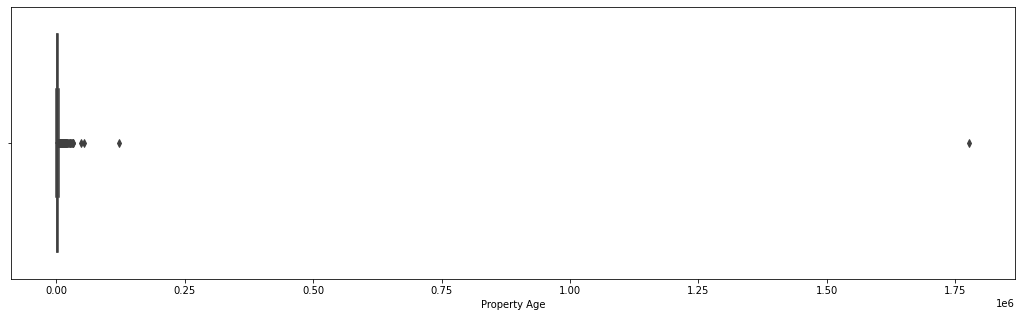

In [302]:
st = 'Property Age'
plt.figure(figsize=(18,5))
sns.boxplot(st,data=train)
train[st].describe()


count    19108.000000
mean      2534.102003
std       1408.509255
min        368.590000
25%       1658.397500
50%       2220.605000
75%       3082.250000
max      30427.680000
Name: Property Age, dtype: float64

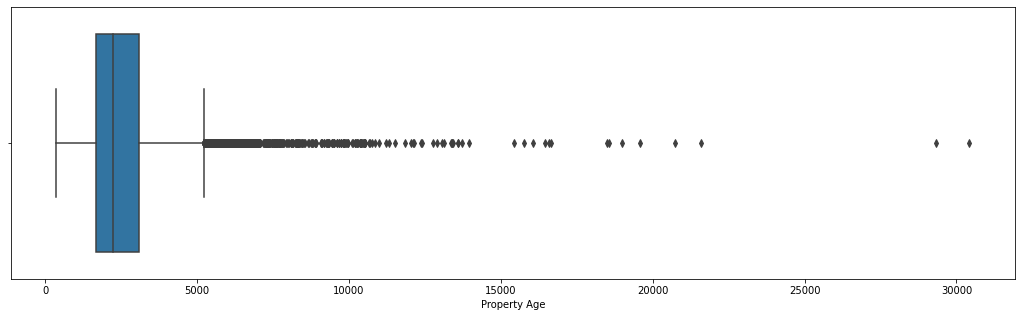

In [303]:
plt.figure(figsize=(18,5))
sns.boxplot(st,data=test)
test[st].describe()

In [304]:
print(train[st].value_counts(dropna=False))
print(test[st].value_counts(dropna=False))

NaN        4850
2415.70       4
1608.43       4
1723.73       3
1946.61       3
           ... 
1375.78       1
2008.72       1
2020.11       1
2491.88       1
4907.72       1
Name: Property Age, Length: 24180, dtype: int64
NaN        892
1923.12      3
1720.04      3
1876.05      3
2248.35      3
          ... 
2515.51      1
3185.09      1
3396.09      1
6650.52      1
3953.43      1
Name: Property Age, Length: 18561, dtype: int64


There are some outliers in Property Age and Property Price

In [305]:
train['Property Age'] = train['Property Age']/(12)
test['Property Age'] = test['Property Age']/(12)
print(train['Property Age'].value_counts(dropna=False))
print(test['Property Age'].value_counts(dropna=False))

NaN           4850
201.308333       4
134.035833       4
192.067500       3
157.205000       3
              ... 
87.103333        1
129.224167       1
122.079167       1
109.068333       1
183.555833       1
Name: Property Age, Length: 24180, dtype: int64
NaN           892
160.260000      3
187.362500      3
170.544167      3
174.815000      3
             ... 
203.745000      1
295.355000      1
128.559167      1
126.617500      1
149.550833      1
Name: Property Age, Length: 18561, dtype: int64


In [306]:
train = train.drop(['Property Age'],axis=1)
test = test.drop(['Property Age'],axis=1)

In [307]:
print(train[train['Property Price']<0]['Property Price'].value_counts(dropna=False))
print(test[test['Property Price']<0]['Property Price'].value_counts(dropna=False))

-999.0    352
Name: Property Price, dtype: int64
-999.0    168
Name: Property Price, dtype: int64


In [308]:
train['Current Loan Expenses (USD)'] = train['Current Loan Expenses (USD)'].fillna(train['Current Loan Expenses (USD)'].mean())
test['Current Loan Expenses (USD)'] = test['Current Loan Expenses (USD)'].fillna(test['Current Loan Expenses (USD)'].mean())
train['Credit Score'] = train['Credit Score'].fillna(train['Credit Score'].mean())
test['Credit Score'] = test['Credit Score'].fillna(test['Credit Score'].mean())

In [309]:
# df = train[train['Property Age'].isna()][['Property Age']]
# df2 = train[~train['Property Age'].isna()][['Property Age','Property Location','Property Type']]
# for i in df.index:
#     train.at[i,'Property Age'] = df2[(df2['Property Location']==train.at[i,'Property Location']) & (df2['Property Type'] == train.at[i,'Property Type'])]['Property Age'].mean()

In [310]:
# df = test[test['Property Age'].isna()][['Property Age']]
# df2 = test[~test['Property Age'].isna()][['Property Age','Property Location','Property Type']]
# for i in df.index:
#     test.at[i,'Property Age'] = df2[(df2['Property Location']==test.at[i,'Property Location']) & (df2['Property Type'] == test.at[i,'Property Type'])]['Property Age'].mean()

In [311]:
df = train[train['Property Price']<0][['Property Price']]
df2 = train[train['Property Price']>0][['Property Price','Property Location','Property Type']]
for i in df.index:
    train.at[i,'Property Price'] = df2[(df2['Property Location']==train.at[i,'Property Location']) & (df2['Property Type'] == train.at[i,'Property Type'])]['Property Price'].mean()

In [312]:
df = test[test['Property Price']<0][['Property Price']]
df2 = test[test['Property Price']>0][['Property Price','Property Location','Property Type']]
for i in df.index:
    test.at[i,'Property Price'] = df2[(df2['Property Location']==test.at[i,'Property Location']) & (df2['Property Type'] == test.at[i,'Property Type'])]['Property Price'].mean()

In [313]:
df = train[train['Income (USD)'].isna()][['Income (USD)']]
df2 = train[~train['Income (USD)'].isna()][['Income (USD)','Profession','Type of Employment']]
for i in df.index:
    train.at[i,'Income (USD)'] = df2[(df2['Profession']==train.at[i,'Profession']) & (df2['Type of Employment'] == train.at[i,'Type of Employment'])]['Income (USD)'].mean()

In [314]:
df = test[test['Income (USD)'].isna()][['Income (USD)']]
df2 = test[~test['Income (USD)'].isna()][['Income (USD)','Profession','Type of Employment']]
for i in df.index:
    test.at[i,'Income (USD)'] = df2[(df2['Profession']==test.at[i,'Profession']) & (df2['Type of Employment'] == test.at[i,'Type of Employment'])]['Income (USD)'].mean()

In [315]:
train.isnull().sum()

Customer ID                      0
Name                             0
Gender                           0
Age                              0
Income (USD)                     0
Income Stability                 0
Profession                       0
Type of Employment               0
Location                         0
Loan Amount Request (USD)        0
Current Loan Expenses (USD)      0
Expense Type 1                   0
Expense Type 2                   0
Dependents                       0
Credit Score                     0
No. of Defaults                  0
Has Active Credit Card           0
Property ID                      0
Property Type                    0
Property Location                0
Co-Applicant                     0
Property Price                   0
Loan Sanction Amount (USD)     340
dtype: int64

In [316]:
train = train.dropna(subset=['Loan Sanction Amount (USD)'])
train = train.replace(-999,0)

In [317]:
train['Loan Saction Fraction'] = round(train['Loan Sanction Amount (USD)']/train['Loan Amount Request (USD)'],2)
train['is loan sactioned'] = 0
train.loc[(train['Loan Sanction Amount (USD)'] > 0), ('is loan sactioned')] = 1
train[['is loan sactioned','Loan Sanction Amount (USD)']]

,is loan sactioned,Loan Sanction Amount (USD)
0,1,54607.18
1,1,37469.98
2,1,36474.43
3,1,56040.54
4,1,74008.28
...,...,...
29995,1,68992.11
29996,1,46616.60
29997,1,61057.56
29998,1,99766.87


In [318]:
test.isnull().sum()

Customer ID                    0
Name                           0
Gender                         0
Age                            0
Income (USD)                   0
Income Stability               0
Profession                     0
Type of Employment             0
Location                       0
Loan Amount Request (USD)      0
Current Loan Expenses (USD)    0
Expense Type 1                 0
Expense Type 2                 0
Dependents                     0
Credit Score                   0
No. of Defaults                0
Has Active Credit Card         0
Property ID                    0
Property Type                  0
Property Location              0
Co-Applicant                   0
Property Price                 0
dtype: int64

In [319]:
train['Age'],bins = pd.cut(train['Age'],8,retbins=True, labels=False)
test['Age'] = pd.cut(test['Age'], bins=bins, labels=False, include_lowest=True)

In [320]:
# train['Property Age'],bins = pd.cut(train['Property Age'],8,retbins=True, labels=False)
# test['Property Age'] = pd.cut(test['Property Age'], bins=bins, labels=False, include_lowest=True)
train['Property Price'],bins = pd.qcut(train['Property Price'],20,retbins=True, labels=False)
test['Property Price'] = pd.cut(test['Property Price'],bins=bins, labels=False, include_lowest=True)

In [321]:
le = LabelEncoder()
Income_Stability = pd.Series(le.fit_transform(train['Expense Type 2']))
print("Correlation (Train set): ", Income_Stability.corr(train['Dependents']))

Income_Stability = pd.Series(le.fit_transform(test['Expense Type 2']))
print("Correlation (Test set): ", Income_Stability.corr(test['Dependents']))


Correlation (Train set):  -0.0061692462265224325
Correlation (Test set):  -0.016246924807895722


### Step 5 : Feature Engineering

__Numerical and One-Hot Coding of Categorical variables__

In [322]:
var_mod = ['Gender', 'Age','Property Price','Income Stability', 'Profession','Type of Employment', 'Location', 'Expense Type 1', 'Expense Type 2', 'Has Active Credit Card', 'Property Location']
le = LabelEncoder()
for i in var_mod:
    train[i] = le.fit_transform(train[i])
    
#One Hot Coding:
train = pd.get_dummies(train, columns=var_mod)

In [323]:
le = LabelEncoder()
for i in var_mod:
    test[i] = le.fit_transform(test[i])
    
#One Hot Coding:
test = pd.get_dummies(test, columns=var_mod)

### Step 6: Building Model

In [324]:
len(train.columns)

69

In [325]:
len(test.columns)

66

Classification Models

In [326]:
train = train.select_dtypes(exclude='object')
test_customer_ID = test['Customer ID']
test = test.select_dtypes(exclude='object')

In [327]:
# Seperate Features and Target
X= train.drop(columns = ['is loan sactioned','Loan Sanction Amount (USD)','Loan Saction Fraction'], axis=1)
y= train['is loan sactioned']
# 20% data as validation set
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=22)

In [328]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
algos = [SVC(), SGDClassifier(), DecisionTreeClassifier(),MLPClassifier()]

names = ['Support Vector Machine', 'Stochastic Gradient Descent', 'Decision Tree', 'Multi-layer perceptron' ]

rmse_list = []
for name in algos:
    model = name
    model.fit(X_train,y_train)
    y_pred = model.predict(X_valid)
    MSE= metrics.mean_squared_error(y_valid,y_pred)
    rmse = np.sqrt(MSE)
    rmse_list.append(rmse)
evaluation = pd.DataFrame({'Algo':algos,'Model': names,'RMSE': rmse_list})
evaluation

,Algo,Model,RMSE
0,SVC(),Support Vector Machine,0.521616
1,SGDClassifier(),Stochastic Gradient Descent,0.521455
2,DecisionTreeClassifier(),Decision Tree,0.406870
3,MLPClassifier(),Multi-layer perceptron,0.521455


In [329]:
model = algos[evaluation[evaluation['Model']==evaluation.min()['Model']]['Algo'].index[0]]
model.fit(X_train,y_train)
test['is loan sactioned'] = model.predict(test)

In [330]:
test['is loan sactioned']

0        0
1        1
2        0
3        1
4        1
        ..
19995    1
19996    1
19997    0
19998    1
19999    1
Name: is loan sactioned, Length: 20000, dtype: int64

Regression Models

In [331]:
# Seperate Features and Target

X= train[train['is loan sactioned']==1].drop(columns = ['is loan sactioned','Loan Sanction Amount (USD)','Loan Saction Fraction'], axis=1)
X_test = test[test['is loan sactioned']==1].drop(columns = ['is loan sactioned'], axis=1)
y= train[train['is loan sactioned']==1]['Loan Saction Fraction']

In [332]:
# 20% data as validation set
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=22)

In [333]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
algos = [LinearRegression(),  Ridge(), Lasso(),
          KNeighborsRegressor(), DecisionTreeRegressor()]

names = ['Linear Regression', 'Ridge Regression', 'Lasso Regression',
         'K Neighbors Regressor', 'Decision Tree Regressor']

rmse_list = []
for name in algos:
    model = name
    model.fit(X_train,y_train)
    y_pred = model.predict(X_valid)
    MSE= metrics.mean_squared_error(y_valid,y_pred)
    rmse = np.sqrt(MSE)
    rmse_list.append(rmse)
evaluation = pd.DataFrame({'Algo':algos,'Model': names,'RMSE': rmse_list})
evaluation

,Algo,Model,RMSE
0,LinearRegression(),Linear Regression,0.042336
1,Ridge(),Ridge Regression,0.042336
2,Lasso(),Lasso Regression,0.045601
3,KNeighborsRegressor(),K Neighbors Regressor,0.057284
4,DecisionTreeRegressor(),Decision Tree Regressor,0.054685


In [334]:
model = algos[evaluation[evaluation['Model']==evaluation.min()['Model']]['Algo'].index[0]]
model.fit(X_train,y_train)

DecisionTreeRegressor()

In [335]:
max(0,100*metrics.r2_score(y_valid, model.predict(X_valid)))

0

In [336]:
predicted_sanction_fraction = model.predict(X_test)
len(test[test['is loan sactioned']==1]['is loan sactioned']),len(predicted_sanction_fraction)

(13745, 13745)

In [353]:
j=0
test['Loan Saction Fraction'] = test['is loan sactioned']
for i in test[test['is loan sactioned']==1].index:
    test.loc[i,'Loan Saction Fraction'] = predicted_sanction_fraction[j]
    j += 1

In [354]:
test['Loan Saction Fraction'].value_counts()

0.00    6255
0.70    3071
0.70    2294
0.75    2246
0.65    1980
0.80    1819
0.65    1196
0.65     308
0.80     276
0.80     213
0.70     188
0.90      53
0.85      51
1.00      33
0.80      17
Name: Loan Saction Fraction, dtype: int64

In [355]:
predicted_sanction_fraction

array([0.75, 0.8 , 0.7 , ..., 0.7 , 0.7 , 0.75])

In [356]:

submission = pd.DataFrame()#read_csv('sample.csv')
submission['Customer ID'] = test_customer_ID
submission['Loan Sanction Amount (USD)'] = test['Loan Saction Fraction']
# submission['Loan Amount Request (USD)']=test['Loan Amount Request (USD)']
submission['Loan Saction Amount (USD)'] = test['Loan Saction Fraction']*test['Loan Amount Request (USD)']
submission.to_csv('my_submission.csv', index=False)